<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:14:02] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


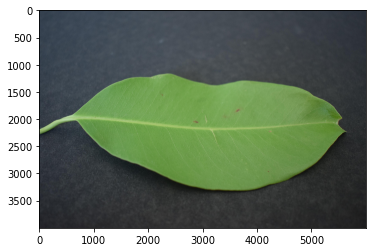

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

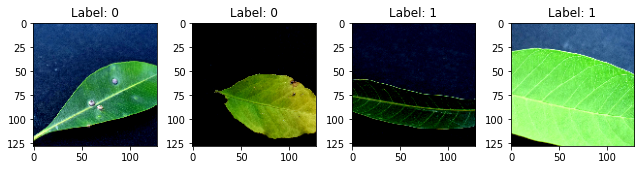

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:14:10] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2207765237881 samples/sec                   batch loss = 1.7504609823226929 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2639973263301183 samples/sec                   batch loss = 1.1544301509857178 | accuracy = 0.35


Epoch[1] Batch[15] Speed: 1.2685186634369268 samples/sec                   batch loss = 0.5290738344192505 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.266050188580717 samples/sec                   batch loss = 0.8564651012420654 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2685822564095584 samples/sec                   batch loss = 0.6727436780929565 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.2626174323702735 samples/sec                   batch loss = 0.6500608325004578 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.263584545197514 samples/sec                   batch loss = 0.4320928454399109 | accuracy = 0.5357142857142857


Epoch[1] Batch[40] Speed: 1.2630602946369978 samples/sec                   batch loss = 0.6454445123672485 | accuracy = 0.54375


Epoch[1] Batch[45] Speed: 1.2682052039511071 samples/sec                   batch loss = 0.3177239000797272 | accuracy = 0.5611111111111111


Epoch[1] Batch[50] Speed: 1.2691653452195741 samples/sec                   batch loss = 0.6362196803092957 | accuracy = 0.55


Epoch[1] Batch[55] Speed: 1.2677606430411477 samples/sec                   batch loss = 0.7057057023048401 | accuracy = 0.55


Epoch[1] Batch[60] Speed: 1.2695079053601117 samples/sec                   batch loss = 0.2611055076122284 | accuracy = 0.55


Epoch[1] Batch[65] Speed: 1.2659584775190944 samples/sec                   batch loss = 0.8779402375221252 | accuracy = 0.5576923076923077


Epoch[1] Batch[70] Speed: 1.2657771962049353 samples/sec                   batch loss = 0.431304931640625 | accuracy = 0.5785714285714286


Epoch[1] Batch[75] Speed: 1.2670609405644522 samples/sec                   batch loss = 0.46334877610206604 | accuracy = 0.5866666666666667


Epoch[1] Batch[80] Speed: 1.2723951595759566 samples/sec                   batch loss = 0.7999671697616577 | accuracy = 0.58125


Epoch[1] Batch[85] Speed: 1.2671056302509964 samples/sec                   batch loss = 0.970316469669342 | accuracy = 0.5794117647058824


Epoch[1] Batch[90] Speed: 1.266423379428075 samples/sec                   batch loss = 0.5408205389976501 | accuracy = 0.5833333333333334


Epoch[1] Batch[95] Speed: 1.2669393278519172 samples/sec                   batch loss = 1.3304579257965088 | accuracy = 0.5842105263157895


Epoch[1] Batch[100] Speed: 1.26678789477694 samples/sec                   batch loss = 0.7942095398902893 | accuracy = 0.59


Epoch[1] Batch[105] Speed: 1.2701660779249764 samples/sec                   batch loss = 1.3905311822891235 | accuracy = 0.5880952380952381


Epoch[1] Batch[110] Speed: 1.2706542849967326 samples/sec                   batch loss = 0.5945705771446228 | accuracy = 0.5840909090909091


Epoch[1] Batch[115] Speed: 1.2679314731803109 samples/sec                   batch loss = 1.255837082862854 | accuracy = 0.5826086956521739


Epoch[1] Batch[120] Speed: 1.2664962274720837 samples/sec                   batch loss = 0.3103373050689697 | accuracy = 0.5895833333333333


Epoch[1] Batch[125] Speed: 1.273223759231835 samples/sec                   batch loss = 0.36944589018821716 | accuracy = 0.596


Epoch[1] Batch[130] Speed: 1.2704373111964924 samples/sec                   batch loss = 0.5171166658401489 | accuracy = 0.5923076923076923


Epoch[1] Batch[135] Speed: 1.2676399495549717 samples/sec                   batch loss = 0.3562931418418884 | accuracy = 0.6


Epoch[1] Batch[140] Speed: 1.2732828964873872 samples/sec                   batch loss = 0.5487977266311646 | accuracy = 0.5982142857142857


Epoch[1] Batch[145] Speed: 1.2726430180268167 samples/sec                   batch loss = 0.7172279953956604 | accuracy = 0.6


Epoch[1] Batch[150] Speed: 1.2750734295887252 samples/sec                   batch loss = 0.5530272722244263 | accuracy = 0.6066666666666667


Epoch[1] Batch[155] Speed: 1.2722911418447962 samples/sec                   batch loss = 0.5730229020118713 | accuracy = 0.6064516129032258


Epoch[1] Batch[160] Speed: 1.2753291187784608 samples/sec                   batch loss = 0.6126707792282104 | accuracy = 0.6078125


Epoch[1] Batch[165] Speed: 1.2707556289689772 samples/sec                   batch loss = 0.49216321110725403 | accuracy = 0.6151515151515151


Epoch[1] Batch[170] Speed: 1.2680088073970284 samples/sec                   batch loss = 0.26134192943573 | accuracy = 0.6176470588235294


Epoch[1] Batch[175] Speed: 1.2704373111964924 samples/sec                   batch loss = 0.6084300875663757 | accuracy = 0.6185714285714285


Epoch[1] Batch[180] Speed: 1.2692256423703023 samples/sec                   batch loss = 0.7854101657867432 | accuracy = 0.6194444444444445


Epoch[1] Batch[185] Speed: 1.2672603938449871 samples/sec                   batch loss = 1.2370483875274658 | accuracy = 0.6135135135135135


Epoch[1] Batch[190] Speed: 1.2654655672134818 samples/sec                   batch loss = 0.3451921045780182 | accuracy = 0.6144736842105263


Epoch[1] Batch[195] Speed: 1.268897533815907 samples/sec                   batch loss = 0.4080938398838043 | accuracy = 0.6141025641025641


Epoch[1] Batch[200] Speed: 1.2657872235827377 samples/sec                   batch loss = 1.3289358615875244 | accuracy = 0.61625


Epoch[1] Batch[205] Speed: 1.2695476762098061 samples/sec                   batch loss = 1.377155065536499 | accuracy = 0.6158536585365854


Epoch[1] Batch[210] Speed: 1.2745035865985057 samples/sec                   batch loss = 0.3700040876865387 | accuracy = 0.6166666666666667


Epoch[1] Batch[215] Speed: 1.274030122219355 samples/sec                   batch loss = 0.45787566900253296 | accuracy = 0.6174418604651163


Epoch[1] Batch[220] Speed: 1.2778502960945979 samples/sec                   batch loss = 0.2882079780101776 | accuracy = 0.6181818181818182


Epoch[1] Batch[225] Speed: 1.271809678409965 samples/sec                   batch loss = 0.451415479183197 | accuracy = 0.6188888888888889


Epoch[1] Batch[230] Speed: 1.2748563971822975 samples/sec                   batch loss = 1.7270399332046509 | accuracy = 0.6173913043478261


Epoch[1] Batch[235] Speed: 1.270436637778999 samples/sec                   batch loss = 0.43914949893951416 | accuracy = 0.6202127659574468


Epoch[1] Batch[240] Speed: 1.2694256817466625 samples/sec                   batch loss = 0.34887656569480896 | accuracy = 0.6208333333333333


Epoch[1] Batch[245] Speed: 1.2769259550791499 samples/sec                   batch loss = 0.43426644802093506 | accuracy = 0.6214285714285714


Epoch[1] Batch[250] Speed: 1.270209929072215 samples/sec                   batch loss = 0.6969760060310364 | accuracy = 0.623


Epoch[1] Batch[255] Speed: 1.2772061116308076 samples/sec                   batch loss = 0.4418796896934509 | accuracy = 0.6254901960784314


Epoch[1] Batch[260] Speed: 1.2711546173716268 samples/sec                   batch loss = 0.2510566711425781 | accuracy = 0.6326923076923077


Epoch[1] Batch[265] Speed: 1.2658186437286612 samples/sec                   batch loss = 0.2759874165058136 | accuracy = 0.6339622641509434


Epoch[1] Batch[270] Speed: 1.2695683311365702 samples/sec                   batch loss = 0.4370327889919281 | accuracy = 0.6351851851851852


Epoch[1] Batch[275] Speed: 1.2638844892098862 samples/sec                   batch loss = 0.4884756803512573 | accuracy = 0.6363636363636364


Epoch[1] Batch[280] Speed: 1.2647414128239374 samples/sec                   batch loss = 0.39666518568992615 | accuracy = 0.6366071428571428


Epoch[1] Batch[285] Speed: 1.2684860541291876 samples/sec                   batch loss = 0.6281131505966187 | accuracy = 0.6385964912280702


Epoch[1] Batch[290] Speed: 1.268390633580824 samples/sec                   batch loss = 0.7103047370910645 | accuracy = 0.6396551724137931


Epoch[1] Batch[295] Speed: 1.2690222104392506 samples/sec                   batch loss = 0.2182232290506363 | accuracy = 0.6432203389830509


Epoch[1] Batch[300] Speed: 1.2742453248778671 samples/sec                   batch loss = 0.28837889432907104 | accuracy = 0.6441666666666667


Epoch[1] Batch[305] Speed: 1.2767240308680607 samples/sec                   batch loss = 0.6910709142684937 | accuracy = 0.6459016393442623


Epoch[1] Batch[310] Speed: 1.2775412555151653 samples/sec                   batch loss = 0.6473153233528137 | accuracy = 0.6475806451612903


Epoch[1] Batch[315] Speed: 1.2721245366362903 samples/sec                   batch loss = 0.6317528486251831 | accuracy = 0.6492063492063492


Epoch[1] Batch[320] Speed: 1.2710976999920751 samples/sec                   batch loss = 1.0218971967697144 | accuracy = 0.64921875


Epoch[1] Batch[325] Speed: 1.2698224897752108 samples/sec                   batch loss = 0.42134374380111694 | accuracy = 0.6515384615384615


Epoch[1] Batch[330] Speed: 1.2803415950437826 samples/sec                   batch loss = 0.6746098399162292 | accuracy = 0.6522727272727272


Epoch[1] Batch[335] Speed: 1.2728843094541682 samples/sec                   batch loss = 1.3723995685577393 | accuracy = 0.6522388059701493


Epoch[1] Batch[340] Speed: 1.2746977389962908 samples/sec                   batch loss = 0.6187757849693298 | accuracy = 0.6514705882352941


Epoch[1] Batch[345] Speed: 1.26750367017557 samples/sec                   batch loss = 0.38628214597702026 | accuracy = 0.6521739130434783


Epoch[1] Batch[350] Speed: 1.2606847991939896 samples/sec                   batch loss = 0.7478258013725281 | accuracy = 0.6507142857142857


Epoch[1] Batch[355] Speed: 1.2632286238183408 samples/sec                   batch loss = 0.5955720543861389 | accuracy = 0.6492957746478873


Epoch[1] Batch[360] Speed: 1.265508808022515 samples/sec                   batch loss = 0.5206453800201416 | accuracy = 0.6513888888888889


Epoch[1] Batch[365] Speed: 1.2628293667538348 samples/sec                   batch loss = 0.5238717794418335 | accuracy = 0.6527397260273973


Epoch[1] Batch[370] Speed: 1.269382364944585 samples/sec                   batch loss = 0.310604453086853 | accuracy = 0.6533783783783784


Epoch[1] Batch[375] Speed: 1.2670789308942976 samples/sec                   batch loss = 0.1780852973461151 | accuracy = 0.6546666666666666


Epoch[1] Batch[380] Speed: 1.2730487953768672 samples/sec                   batch loss = 0.6834864616394043 | accuracy = 0.655921052631579


Epoch[1] Batch[385] Speed: 1.267103429186204 samples/sec                   batch loss = 0.5391843318939209 | accuracy = 0.6571428571428571


Epoch[1] Batch[390] Speed: 1.2708998289757643 samples/sec                   batch loss = 0.8835296034812927 | accuracy = 0.6583333333333333


Epoch[1] Batch[395] Speed: 1.2664519631602118 samples/sec                   batch loss = 0.4523850679397583 | accuracy = 0.6582278481012658


Epoch[1] Batch[400] Speed: 1.267205068936292 samples/sec                   batch loss = 0.9010927081108093 | accuracy = 0.659375


Epoch[1] Batch[405] Speed: 1.2646489379897323 samples/sec                   batch loss = 1.0635676383972168 | accuracy = 0.658641975308642


Epoch[1] Batch[410] Speed: 1.259411383455014 samples/sec                   batch loss = 0.7715985774993896 | accuracy = 0.6591463414634147


Epoch[1] Batch[415] Speed: 1.2726104859265974 samples/sec                   batch loss = 0.5143235921859741 | accuracy = 0.6608433734939759


Epoch[1] Batch[420] Speed: 1.271989316549386 samples/sec                   batch loss = 1.286828637123108 | accuracy = 0.6613095238095238


Epoch[1] Batch[425] Speed: 1.2736343546620248 samples/sec                   batch loss = 1.166967511177063 | accuracy = 0.6617647058823529


Epoch[1] Batch[430] Speed: 1.2733369171799758 samples/sec                   batch loss = 0.3932965397834778 | accuracy = 0.6633720930232558


Epoch[1] Batch[435] Speed: 1.267658531023535 samples/sec                   batch loss = 1.006265640258789 | accuracy = 0.6637931034482759


Epoch[1] Batch[440] Speed: 1.2706251263357127 samples/sec                   batch loss = 0.2802319824695587 | accuracy = 0.6659090909090909


Epoch[1] Batch[445] Speed: 1.2672003789844883 samples/sec                   batch loss = 0.32685184478759766 | accuracy = 0.6651685393258427


Epoch[1] Batch[450] Speed: 1.2686651382688816 samples/sec                   batch loss = 0.9141222834587097 | accuracy = 0.665


Epoch[1] Batch[455] Speed: 1.2657606752527848 samples/sec                   batch loss = 0.32484814524650574 | accuracy = 0.6659340659340659


Epoch[1] Batch[460] Speed: 1.2708850994371272 samples/sec                   batch loss = 0.8542053699493408 | accuracy = 0.6684782608695652


Epoch[1] Batch[465] Speed: 1.2639132440989074 samples/sec                   batch loss = 0.5930079221725464 | accuracy = 0.667741935483871


Epoch[1] Batch[470] Speed: 1.270736956595011 samples/sec                   batch loss = 0.5698004961013794 | accuracy = 0.6675531914893617


Epoch[1] Batch[475] Speed: 1.2667997555682557 samples/sec                   batch loss = 0.9730772972106934 | accuracy = 0.6678947368421052


Epoch[1] Batch[480] Speed: 1.2638814424108915 samples/sec                   batch loss = 0.4516065716743469 | accuracy = 0.66875


Epoch[1] Batch[485] Speed: 1.2695382616289668 samples/sec                   batch loss = 0.2160852700471878 | accuracy = 0.6711340206185566


Epoch[1] Batch[490] Speed: 1.2572525836406545 samples/sec                   batch loss = 0.5104745626449585 | accuracy = 0.6714285714285714


Epoch[1] Batch[495] Speed: 1.2594867362972617 samples/sec                   batch loss = 0.5546918511390686 | accuracy = 0.6702020202020202


Epoch[1] Batch[500] Speed: 1.2608453890680393 samples/sec                   batch loss = 0.41088804602622986 | accuracy = 0.671


Epoch[1] Batch[505] Speed: 1.259834686466124 samples/sec                   batch loss = 0.3709404468536377 | accuracy = 0.6698019801980198


Epoch[1] Batch[510] Speed: 1.2543790739037857 samples/sec                   batch loss = 0.6524812579154968 | accuracy = 0.6700980392156862


Epoch[1] Batch[515] Speed: 1.2743542118281062 samples/sec                   batch loss = 0.19509786367416382 | accuracy = 0.670873786407767


Epoch[1] Batch[520] Speed: 1.2625908268015902 samples/sec                   batch loss = 0.7221920490264893 | accuracy = 0.6692307692307692


Epoch[1] Batch[525] Speed: 1.25703630066105 samples/sec                   batch loss = 0.15581659972667694 | accuracy = 0.6695238095238095


Epoch[1] Batch[530] Speed: 1.2666124001546761 samples/sec                   batch loss = 0.34203392267227173 | accuracy = 0.6698113207547169


Epoch[1] Batch[535] Speed: 1.271485917965091 samples/sec                   batch loss = 0.32196876406669617 | accuracy = 0.6700934579439253


Epoch[1] Batch[540] Speed: 1.2713652849073447 samples/sec                   batch loss = 0.39461639523506165 | accuracy = 0.6703703703703704


Epoch[1] Batch[545] Speed: 1.2705015777507498 samples/sec                   batch loss = 0.4065650403499603 | accuracy = 0.6701834862385321


Epoch[1] Batch[550] Speed: 1.2749873829018923 samples/sec                   batch loss = 0.6408564448356628 | accuracy = 0.6704545454545454


Epoch[1] Batch[555] Speed: 1.269759829500023 samples/sec                   batch loss = 0.2749721109867096 | accuracy = 0.6707207207207208


Epoch[1] Batch[560] Speed: 1.2709374726812943 samples/sec                   batch loss = 0.31974565982818604 | accuracy = 0.6705357142857142


Epoch[1] Batch[565] Speed: 1.272327131213407 samples/sec                   batch loss = 0.3302895128726959 | accuracy = 0.6730088495575222


Epoch[1] Batch[570] Speed: 1.2740765626848687 samples/sec                   batch loss = 0.36887574195861816 | accuracy = 0.6728070175438596


Epoch[1] Batch[575] Speed: 1.2741382950446174 samples/sec                   batch loss = 0.8287153244018555 | accuracy = 0.6717391304347826


Epoch[1] Batch[580] Speed: 1.2777535588828357 samples/sec                   batch loss = 0.17253123223781586 | accuracy = 0.6737068965517241


Epoch[1] Batch[585] Speed: 1.276094569582806 samples/sec                   batch loss = 0.5843590497970581 | accuracy = 0.6743589743589744


Epoch[1] Batch[590] Speed: 1.274762243604331 samples/sec                   batch loss = 0.5435346961021423 | accuracy = 0.6741525423728814


Epoch[1] Batch[595] Speed: 1.2703825743039678 samples/sec                   batch loss = 0.5427324175834656 | accuracy = 0.673109243697479


Epoch[1] Batch[600] Speed: 1.27380628796808 samples/sec                   batch loss = 0.3958302438259125 | accuracy = 0.6733333333333333


Epoch[1] Batch[605] Speed: 1.269531633079284 samples/sec                   batch loss = 0.9824222326278687 | accuracy = 0.6735537190082644


Epoch[1] Batch[610] Speed: 1.2691732180892188 samples/sec                   batch loss = 0.3704136610031128 | accuracy = 0.6733606557377049


Epoch[1] Batch[615] Speed: 1.270342751128544 samples/sec                   batch loss = 0.6987048387527466 | accuracy = 0.6739837398373983


Epoch[1] Batch[620] Speed: 1.2681260245709576 samples/sec                   batch loss = 0.186214417219162 | accuracy = 0.6741935483870968


Epoch[1] Batch[625] Speed: 1.2704728109293937 samples/sec                   batch loss = 0.5275852680206299 | accuracy = 0.6748


Epoch[1] Batch[630] Speed: 1.2655840330717736 samples/sec                   batch loss = 0.5170052647590637 | accuracy = 0.675


Epoch[1] Batch[635] Speed: 1.2695796676145952 samples/sec                   batch loss = 0.14795172214508057 | accuracy = 0.6755905511811023


Epoch[1] Batch[640] Speed: 1.2675967545347149 samples/sec                   batch loss = 1.2426117658615112 | accuracy = 0.675390625


Epoch[1] Batch[645] Speed: 1.2724336639580618 samples/sec                   batch loss = 1.1143308877944946 | accuracy = 0.6751937984496124


Epoch[1] Batch[650] Speed: 1.2719627002896583 samples/sec                   batch loss = 0.5813760757446289 | accuracy = 0.675


Epoch[1] Batch[655] Speed: 1.263308144049761 samples/sec                   batch loss = 0.7446377873420715 | accuracy = 0.6740458015267176


Epoch[1] Batch[660] Speed: 1.2762222178778502 samples/sec                   batch loss = 0.5605605244636536 | accuracy = 0.6753787878787879


Epoch[1] Batch[665] Speed: 1.2716875380318893 samples/sec                   batch loss = 0.5270624160766602 | accuracy = 0.6763157894736842


Epoch[1] Batch[670] Speed: 1.2640105633969947 samples/sec                   batch loss = 0.4376694858074188 | accuracy = 0.6772388059701493


Epoch[1] Batch[675] Speed: 1.265557302334556 samples/sec                   batch loss = 0.319909930229187 | accuracy = 0.677037037037037


Epoch[1] Batch[680] Speed: 1.2705741259547831 samples/sec                   batch loss = 0.4567180275917053 | accuracy = 0.6775735294117647


Epoch[1] Batch[685] Speed: 1.2743325297427146 samples/sec                   batch loss = 0.6870396137237549 | accuracy = 0.6762773722627737


Epoch[1] Batch[690] Speed: 1.2701762711233076 samples/sec                   batch loss = 0.44693905115127563 | accuracy = 0.6757246376811594


Epoch[1] Batch[695] Speed: 1.26145771114652 samples/sec                   batch loss = 0.7041304111480713 | accuracy = 0.6766187050359712


Epoch[1] Batch[700] Speed: 1.2674562713574058 samples/sec                   batch loss = 0.6337010264396667 | accuracy = 0.6764285714285714


Epoch[1] Batch[705] Speed: 1.2685518499243167 samples/sec                   batch loss = 0.7044453024864197 | accuracy = 0.6776595744680851


Epoch[1] Batch[710] Speed: 1.267260872455238 samples/sec                   batch loss = 0.88374924659729 | accuracy = 0.6788732394366197


Epoch[1] Batch[715] Speed: 1.262444136230544 samples/sec                   batch loss = 0.47870782017707825 | accuracy = 0.6800699300699301


Epoch[1] Batch[720] Speed: 1.269508385669518 samples/sec                   batch loss = 0.16390886902809143 | accuracy = 0.6798611111111111


Epoch[1] Batch[725] Speed: 1.27096125386967 samples/sec                   batch loss = 0.8294779062271118 | accuracy = 0.6786206896551724


Epoch[1] Batch[730] Speed: 1.2714038233319338 samples/sec                   batch loss = 0.8365394473075867 | accuracy = 0.6773972602739726


Epoch[1] Batch[735] Speed: 1.2712597015938696 samples/sec                   batch loss = 0.39523380994796753 | accuracy = 0.6785714285714286


Epoch[1] Batch[740] Speed: 1.2714298380893558 samples/sec                   batch loss = 0.4456315338611603 | accuracy = 0.6777027027027027


Epoch[1] Batch[745] Speed: 1.2690578231184457 samples/sec                   batch loss = 0.8862826824188232 | accuracy = 0.6778523489932886


Epoch[1] Batch[750] Speed: 1.2681008157780942 samples/sec                   batch loss = 0.5672587752342224 | accuracy = 0.6783333333333333


Epoch[1] Batch[755] Speed: 1.2727968198772541 samples/sec                   batch loss = 0.2609485387802124 | accuracy = 0.6778145695364238


Epoch[1] Batch[760] Speed: 1.2685183757004095 samples/sec                   batch loss = 0.5335798263549805 | accuracy = 0.6773026315789473


Epoch[1] Batch[765] Speed: 1.2669422937378878 samples/sec                   batch loss = 0.5708950757980347 | accuracy = 0.677124183006536


Epoch[1] Batch[770] Speed: 1.26602429796623 samples/sec                   batch loss = 0.6386944055557251 | accuracy = 0.6775974025974026


Epoch[1] Batch[775] Speed: 1.2625433196462366 samples/sec                   batch loss = 0.19845591485500336 | accuracy = 0.6787096774193548


Epoch[1] Batch[780] Speed: 1.2747878148053564 samples/sec                   batch loss = 0.5451313257217407 | accuracy = 0.6791666666666667


Epoch[1] Batch[785] Speed: 1.271260375884205 samples/sec                   batch loss = 0.665744423866272 | accuracy = 0.6792993630573249


[Epoch 1] training: accuracy=0.6798857868020305
[Epoch 1] time cost: 647.9071860313416
[Epoch 1] validation: validation accuracy=0.77


Epoch[2] Batch[5] Speed: 1.2674218017161987 samples/sec                   batch loss = 0.3222199082374573 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2728187394257149 samples/sec                   batch loss = 0.5048724412918091 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.2705336172490458 samples/sec                   batch loss = 0.3479226529598236 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.271175902506602 samples/sec                   batch loss = 0.47681400179862976 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2735903634396137 samples/sec                   batch loss = 0.35869696736335754 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2695945590586188 samples/sec                   batch loss = 0.24302776157855988 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2711584698319118 samples/sec                   batch loss = 0.252027302980423 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2721528959929633 samples/sec                   batch loss = 0.33257174491882324 | accuracy = 0.775


Epoch[2] Batch[45] Speed: 1.2660157953754836 samples/sec                   batch loss = 0.8114836812019348 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.2695911964439495 samples/sec                   batch loss = 0.3037477135658264 | accuracy = 0.77


Epoch[2] Batch[55] Speed: 1.2723890801496966 samples/sec                   batch loss = 0.3878873586654663 | accuracy = 0.7772727272727272


Epoch[2] Batch[60] Speed: 1.2673968123986783 samples/sec                   batch loss = 0.6489866375923157 | accuracy = 0.775


Epoch[2] Batch[65] Speed: 1.276772222567216 samples/sec                   batch loss = 0.2919025123119354 | accuracy = 0.7807692307692308


Epoch[2] Batch[70] Speed: 1.2780883086173673 samples/sec                   batch loss = 0.435102254152298 | accuracy = 0.775


Epoch[2] Batch[75] Speed: 1.2665638249508577 samples/sec                   batch loss = 0.24457162618637085 | accuracy = 0.77


Epoch[2] Batch[80] Speed: 1.2700486756145013 samples/sec                   batch loss = 0.8775511980056763 | accuracy = 0.759375


Epoch[2] Batch[85] Speed: 1.2707050030837508 samples/sec                   batch loss = 0.23589198291301727 | accuracy = 0.7647058823529411


Epoch[2] Batch[90] Speed: 1.275174510519275 samples/sec                   batch loss = 0.20908865332603455 | accuracy = 0.7638888888888888


Epoch[2] Batch[95] Speed: 1.273615017486645 samples/sec                   batch loss = 0.5969404578208923 | accuracy = 0.7631578947368421


Epoch[2] Batch[100] Speed: 1.2731245330754284 samples/sec                   batch loss = 0.3150882124900818 | accuracy = 0.77


Epoch[2] Batch[105] Speed: 1.2757206051964358 samples/sec                   batch loss = 0.28966280817985535 | accuracy = 0.7714285714285715


Epoch[2] Batch[110] Speed: 1.2761780477077698 samples/sec                   batch loss = 0.4984350800514221 | accuracy = 0.7704545454545455


Epoch[2] Batch[115] Speed: 1.2749976536302234 samples/sec                   batch loss = 0.14572274684906006 | accuracy = 0.7652173913043478


Epoch[2] Batch[120] Speed: 1.2672717848670496 samples/sec                   batch loss = 0.3238762319087982 | accuracy = 0.7645833333333333


Epoch[2] Batch[125] Speed: 1.273187236024034 samples/sec                   batch loss = 0.4291466474533081 | accuracy = 0.764


Epoch[2] Batch[130] Speed: 1.275614491256333 samples/sec                   batch loss = 0.4420129358768463 | accuracy = 0.7673076923076924


Epoch[2] Batch[135] Speed: 1.2730357547182982 samples/sec                   batch loss = 0.44236433506011963 | accuracy = 0.7685185185185185


Epoch[2] Batch[140] Speed: 1.2735820489566319 samples/sec                   batch loss = 0.33772018551826477 | accuracy = 0.7642857142857142


Epoch[2] Batch[145] Speed: 1.2770383140053456 samples/sec                   batch loss = 0.24953123927116394 | accuracy = 0.7672413793103449


Epoch[2] Batch[150] Speed: 1.2731321653075989 samples/sec                   batch loss = 0.36138424277305603 | accuracy = 0.7683333333333333


Epoch[2] Batch[155] Speed: 1.2688109752362324 samples/sec                   batch loss = 0.39986881613731384 | accuracy = 0.7677419354838709


Epoch[2] Batch[160] Speed: 1.273152550578838 samples/sec                   batch loss = 0.8020245432853699 | accuracy = 0.7671875


Epoch[2] Batch[165] Speed: 1.2714043050770263 samples/sec                   batch loss = 0.6878966689109802 | accuracy = 0.7681818181818182


Epoch[2] Batch[170] Speed: 1.2690406404711267 samples/sec                   batch loss = 0.16934406757354736 | accuracy = 0.7661764705882353


Epoch[2] Batch[175] Speed: 1.2768825136322977 samples/sec                   batch loss = 0.6411942839622498 | accuracy = 0.7628571428571429


Epoch[2] Batch[180] Speed: 1.278527282340334 samples/sec                   batch loss = 0.3922419548034668 | accuracy = 0.7638888888888888


Epoch[2] Batch[185] Speed: 1.2731066604847259 samples/sec                   batch loss = 0.824668824672699 | accuracy = 0.7581081081081081


Epoch[2] Batch[190] Speed: 1.267976799278388 samples/sec                   batch loss = 0.5833063125610352 | accuracy = 0.7578947368421053


Epoch[2] Batch[195] Speed: 1.2764248573788382 samples/sec                   batch loss = 0.2160356491804123 | accuracy = 0.7589743589743589


Epoch[2] Batch[200] Speed: 1.267188032134514 samples/sec                   batch loss = 0.35582324862480164 | accuracy = 0.7575


Epoch[2] Batch[205] Speed: 1.2752863675413584 samples/sec                   batch loss = 0.7987603545188904 | accuracy = 0.7573170731707317


Epoch[2] Batch[210] Speed: 1.277923686003332 samples/sec                   batch loss = 0.36530181765556335 | accuracy = 0.7583333333333333


Epoch[2] Batch[215] Speed: 1.2732783547060262 samples/sec                   batch loss = 0.1824313849210739 | accuracy = 0.7593023255813953


Epoch[2] Batch[220] Speed: 1.2691458554868689 samples/sec                   batch loss = 0.12125571817159653 | accuracy = 0.7568181818181818


Epoch[2] Batch[225] Speed: 1.2736348380989326 samples/sec                   batch loss = 0.31375962495803833 | accuracy = 0.76


Epoch[2] Batch[230] Speed: 1.2684663934449778 samples/sec                   batch loss = 0.7999890446662903 | accuracy = 0.7576086956521739


Epoch[2] Batch[235] Speed: 1.2749829258448562 samples/sec                   batch loss = 0.23954786360263824 | accuracy = 0.7574468085106383


Epoch[2] Batch[240] Speed: 1.274090785754638 samples/sec                   batch loss = 0.7312881946563721 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.2768723096942867 samples/sec                   batch loss = 0.4975298047065735 | accuracy = 0.7510204081632653


Epoch[2] Batch[250] Speed: 1.2686963176973711 samples/sec                   batch loss = 0.20575585961341858 | accuracy = 0.752


Epoch[2] Batch[255] Speed: 1.273867510525008 samples/sec                   batch loss = 1.3526352643966675 | accuracy = 0.746078431372549


Epoch[2] Batch[260] Speed: 1.2737145135155716 samples/sec                   batch loss = 0.3632381558418274 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.277251130893602 samples/sec                   batch loss = 0.9559845924377441 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2736415095657392 samples/sec                   batch loss = 0.9776934385299683 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.2691481596605199 samples/sec                   batch loss = 0.5213044285774231 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2705868275535894 samples/sec                   batch loss = 0.4230356216430664 | accuracy = 0.75


Epoch[2] Batch[285] Speed: 1.269302174233596 samples/sec                   batch loss = 0.5859345197677612 | accuracy = 0.7508771929824561


Epoch[2] Batch[290] Speed: 1.2718840152536177 samples/sec                   batch loss = 0.244981050491333 | accuracy = 0.753448275862069


Epoch[2] Batch[295] Speed: 1.273631067300784 samples/sec                   batch loss = 0.4427659511566162 | accuracy = 0.7550847457627119


Epoch[2] Batch[300] Speed: 1.2764828355707825 samples/sec                   batch loss = 0.46991539001464844 | accuracy = 0.755


Epoch[2] Batch[305] Speed: 1.2723320521700237 samples/sec                   batch loss = 0.19864855706691742 | accuracy = 0.7549180327868853


Epoch[2] Batch[310] Speed: 1.2729871685425604 samples/sec                   batch loss = 0.8085620999336243 | accuracy = 0.7540322580645161


Epoch[2] Batch[315] Speed: 1.2731522607362833 samples/sec                   batch loss = 0.3655098080635071 | accuracy = 0.7547619047619047


Epoch[2] Batch[320] Speed: 1.269356914100439 samples/sec                   batch loss = 0.5346390008926392 | accuracy = 0.75390625


Epoch[2] Batch[325] Speed: 1.2716214165666557 samples/sec                   batch loss = 0.45221036672592163 | accuracy = 0.7530769230769231


Epoch[2] Batch[330] Speed: 1.2729015963453922 samples/sec                   batch loss = 2.1219592094421387 | accuracy = 0.753030303030303


Epoch[2] Batch[335] Speed: 1.2706548624094736 samples/sec                   batch loss = 0.7137277722358704 | accuracy = 0.7529850746268657


Epoch[2] Batch[340] Speed: 1.2752823930821704 samples/sec                   batch loss = 0.7515519857406616 | accuracy = 0.7529411764705882


Epoch[2] Batch[345] Speed: 1.2669569320236553 samples/sec                   batch loss = 0.4386676847934723 | accuracy = 0.7528985507246376


Epoch[2] Batch[350] Speed: 1.278132513750394 samples/sec                   batch loss = 0.9401334524154663 | accuracy = 0.7542857142857143


Epoch[2] Batch[355] Speed: 1.27062647357109 samples/sec                   batch loss = 0.7204787135124207 | accuracy = 0.7535211267605634


Epoch[2] Batch[360] Speed: 1.2710722766166775 samples/sec                   batch loss = 0.6085124015808105 | accuracy = 0.7513888888888889


Epoch[2] Batch[365] Speed: 1.2734963967658754 samples/sec                   batch loss = 0.5916686654090881 | accuracy = 0.7493150684931507


Epoch[2] Batch[370] Speed: 1.27235993830988 samples/sec                   batch loss = 0.4444979727268219 | accuracy = 0.7493243243243243


Epoch[2] Batch[375] Speed: 1.2698226819941583 samples/sec                   batch loss = 0.80724036693573 | accuracy = 0.7493333333333333


Epoch[2] Batch[380] Speed: 1.2708376399128627 samples/sec                   batch loss = 0.4776995778083801 | accuracy = 0.7486842105263158


Epoch[2] Batch[385] Speed: 1.2783134556131044 samples/sec                   batch loss = 1.60648512840271 | accuracy = 0.7474025974025974


Epoch[2] Batch[390] Speed: 1.2716360667939524 samples/sec                   batch loss = 0.4566992223262787 | accuracy = 0.7487179487179487


Epoch[2] Batch[395] Speed: 1.2718814118710182 samples/sec                   batch loss = 0.6381816864013672 | accuracy = 0.7462025316455696


Epoch[2] Batch[400] Speed: 1.2708881800967096 samples/sec                   batch loss = 0.509843647480011 | accuracy = 0.74625


Epoch[2] Batch[405] Speed: 1.27664407565105 samples/sec                   batch loss = 0.3040402829647064 | accuracy = 0.7462962962962963


Epoch[2] Batch[410] Speed: 1.2736652953640153 samples/sec                   batch loss = 0.5223941206932068 | accuracy = 0.7451219512195122


Epoch[2] Batch[415] Speed: 1.270309855605858 samples/sec                   batch loss = 1.1023032665252686 | accuracy = 0.7469879518072289


Epoch[2] Batch[420] Speed: 1.267991461479464 samples/sec                   batch loss = 0.5531249642372131 | accuracy = 0.7482142857142857


Epoch[2] Batch[425] Speed: 1.267560170367806 samples/sec                   batch loss = 0.6216500401496887 | accuracy = 0.7494117647058823


Epoch[2] Batch[430] Speed: 1.2713322400688725 samples/sec                   batch loss = 0.17192378640174866 | accuracy = 0.7517441860465116


Epoch[2] Batch[435] Speed: 1.2750580217270069 samples/sec                   batch loss = 0.5544857382774353 | accuracy = 0.7517241379310344


Epoch[2] Batch[440] Speed: 1.2699352361805394 samples/sec                   batch loss = 0.2486693561077118 | accuracy = 0.7511363636363636


Epoch[2] Batch[445] Speed: 1.2736948838164106 samples/sec                   batch loss = 0.6176378130912781 | accuracy = 0.749438202247191


Epoch[2] Batch[450] Speed: 1.2712663482012574 samples/sec                   batch loss = 0.27074676752090454 | accuracy = 0.75


Epoch[2] Batch[455] Speed: 1.2685854218372181 samples/sec                   batch loss = 1.1154073476791382 | accuracy = 0.7505494505494505


Epoch[2] Batch[460] Speed: 1.2742532608979644 samples/sec                   batch loss = 0.9882041811943054 | accuracy = 0.7494565217391305


Epoch[2] Batch[465] Speed: 1.2685336259157092 samples/sec                   batch loss = 0.7154351472854614 | accuracy = 0.75


Epoch[2] Batch[470] Speed: 1.2741398432684634 samples/sec                   batch loss = 0.21774381399154663 | accuracy = 0.75


Epoch[2] Batch[475] Speed: 1.2740713379634805 samples/sec                   batch loss = 0.32685065269470215 | accuracy = 0.7489473684210526


Epoch[2] Batch[480] Speed: 1.269269812708513 samples/sec                   batch loss = 0.5142417550086975 | accuracy = 0.746875


Epoch[2] Batch[485] Speed: 1.2642173452274883 samples/sec                   batch loss = 0.3619309663772583 | accuracy = 0.7479381443298969


Epoch[2] Batch[490] Speed: 1.2663949881687908 samples/sec                   batch loss = 0.41533321142196655 | accuracy = 0.7479591836734694


Epoch[2] Batch[495] Speed: 1.2718335886645813 samples/sec                   batch loss = 0.36892613768577576 | accuracy = 0.7464646464646465


Epoch[2] Batch[500] Speed: 1.2706006841328275 samples/sec                   batch loss = 0.5261276960372925 | accuracy = 0.7455


Epoch[2] Batch[505] Speed: 1.2745567426465512 samples/sec                   batch loss = 0.4687882363796234 | accuracy = 0.745049504950495


Epoch[2] Batch[510] Speed: 1.2727841706135465 samples/sec                   batch loss = 0.3664669692516327 | accuracy = 0.7446078431372549


Epoch[2] Batch[515] Speed: 1.273512443590471 samples/sec                   batch loss = 0.43788841366767883 | accuracy = 0.7436893203883496


Epoch[2] Batch[520] Speed: 1.273958339661153 samples/sec                   batch loss = 0.26461002230644226 | accuracy = 0.7427884615384616


Epoch[2] Batch[525] Speed: 1.2723885011597493 samples/sec                   batch loss = 0.3239883780479431 | accuracy = 0.7438095238095238


Epoch[2] Batch[530] Speed: 1.2751638492624788 samples/sec                   batch loss = 0.4951377511024475 | accuracy = 0.744811320754717


Epoch[2] Batch[535] Speed: 1.2715533745411265 samples/sec                   batch loss = 0.41569024324417114 | accuracy = 0.7453271028037384


Epoch[2] Batch[540] Speed: 1.2689054993340165 samples/sec                   batch loss = 1.1983411312103271 | accuracy = 0.7444444444444445


Epoch[2] Batch[545] Speed: 1.2671715700421446 samples/sec                   batch loss = 0.41231584548950195 | accuracy = 0.7444954128440368


Epoch[2] Batch[550] Speed: 1.2714919887638447 samples/sec                   batch loss = 0.44132620096206665 | accuracy = 0.7445454545454545


Epoch[2] Batch[555] Speed: 1.2675681191040842 samples/sec                   batch loss = 0.4438438415527344 | accuracy = 0.7450450450450451


Epoch[2] Batch[560] Speed: 1.2670528068064262 samples/sec                   batch loss = 0.3328535258769989 | accuracy = 0.7446428571428572


Epoch[2] Batch[565] Speed: 1.2713445714694915 samples/sec                   batch loss = 0.5587763786315918 | accuracy = 0.7442477876106195


Epoch[2] Batch[570] Speed: 1.2667298374949318 samples/sec                   batch loss = 0.37110602855682373 | accuracy = 0.7447368421052631


Epoch[2] Batch[575] Speed: 1.2696756515035326 samples/sec                   batch loss = 0.18483175337314606 | accuracy = 0.7452173913043478


Epoch[2] Batch[580] Speed: 1.2649956452951734 samples/sec                   batch loss = 0.40058428049087524 | accuracy = 0.7456896551724138


Epoch[2] Batch[585] Speed: 1.2719282743884766 samples/sec                   batch loss = 0.4473123252391815 | accuracy = 0.7465811965811966


Epoch[2] Batch[590] Speed: 1.2707125100895638 samples/sec                   batch loss = 0.36621326208114624 | accuracy = 0.7470338983050847


Epoch[2] Batch[595] Speed: 1.2658575151862088 samples/sec                   batch loss = 0.533715009689331 | accuracy = 0.7478991596638656


Epoch[2] Batch[600] Speed: 1.270422784777537 samples/sec                   batch loss = 0.42995092272758484 | accuracy = 0.7483333333333333


Epoch[2] Batch[605] Speed: 1.27005502113047 samples/sec                   batch loss = 0.1421545147895813 | accuracy = 0.7483471074380166


Epoch[2] Batch[610] Speed: 1.267637171959565 samples/sec                   batch loss = 0.3433123230934143 | accuracy = 0.7487704918032787


Epoch[2] Batch[615] Speed: 1.2676062361162561 samples/sec                   batch loss = 0.9481257200241089 | accuracy = 0.7483739837398374


Epoch[2] Batch[620] Speed: 1.2651878655740305 samples/sec                   batch loss = 0.5326570272445679 | accuracy = 0.7467741935483871


Epoch[2] Batch[625] Speed: 1.2702165647069228 samples/sec                   batch loss = 0.5240460634231567 | accuracy = 0.7472


Epoch[2] Batch[630] Speed: 1.274095720363246 samples/sec                   batch loss = 1.1366944313049316 | accuracy = 0.748015873015873


Epoch[2] Batch[635] Speed: 1.2668847962944645 samples/sec                   batch loss = 0.29760977625846863 | accuracy = 0.7488188976377953


Epoch[2] Batch[640] Speed: 1.2634733041702215 samples/sec                   batch loss = 0.44776299595832825 | accuracy = 0.748046875


Epoch[2] Batch[645] Speed: 1.2669513828297636 samples/sec                   batch loss = 0.17972537875175476 | accuracy = 0.7492248062015504


Epoch[2] Batch[650] Speed: 1.264261548737759 samples/sec                   batch loss = 0.3562329411506653 | accuracy = 0.7503846153846154


Epoch[2] Batch[655] Speed: 1.2643909379825624 samples/sec                   batch loss = 1.0813276767730713 | accuracy = 0.75


Epoch[2] Batch[660] Speed: 1.262021831184619 samples/sec                   batch loss = 0.2456934154033661 | accuracy = 0.75


Epoch[2] Batch[665] Speed: 1.2675505937095184 samples/sec                   batch loss = 0.49621936678886414 | accuracy = 0.7507518796992482


Epoch[2] Batch[670] Speed: 1.2638132741246284 samples/sec                   batch loss = 0.5156595706939697 | accuracy = 0.7518656716417911


Epoch[2] Batch[675] Speed: 1.265086167568938 samples/sec                   batch loss = 0.3692863881587982 | accuracy = 0.7522222222222222


Epoch[2] Batch[680] Speed: 1.2701275183434426 samples/sec                   batch loss = 0.6894309520721436 | accuracy = 0.7522058823529412


Epoch[2] Batch[685] Speed: 1.268743041740708 samples/sec                   batch loss = 0.545440673828125 | accuracy = 0.7514598540145986


Epoch[2] Batch[690] Speed: 1.2755613439257467 samples/sec                   batch loss = 0.26885172724723816 | accuracy = 0.7528985507246376


Epoch[2] Batch[695] Speed: 1.2645177803894714 samples/sec                   batch loss = 0.35367637872695923 | accuracy = 0.7532374100719424


Epoch[2] Batch[700] Speed: 1.270432020078277 samples/sec                   batch loss = 0.3277991712093353 | accuracy = 0.7517857142857143


Epoch[2] Batch[705] Speed: 1.2728409494298616 samples/sec                   batch loss = 0.4341604709625244 | accuracy = 0.7524822695035461


Epoch[2] Batch[710] Speed: 1.271213177288122 samples/sec                   batch loss = 0.9890212416648865 | accuracy = 0.7528169014084507


Epoch[2] Batch[715] Speed: 1.2724926313257 samples/sec                   batch loss = 0.7149397134780884 | accuracy = 0.7534965034965035


Epoch[2] Batch[720] Speed: 1.273455894832433 samples/sec                   batch loss = 0.4408322274684906 | accuracy = 0.753125


Epoch[2] Batch[725] Speed: 1.271164248566123 samples/sec                   batch loss = 0.288055419921875 | accuracy = 0.753448275862069


Epoch[2] Batch[730] Speed: 1.2664179305018233 samples/sec                   batch loss = 0.3810594975948334 | accuracy = 0.7534246575342466


Epoch[2] Batch[735] Speed: 1.2753601418788534 samples/sec                   batch loss = 0.7277165055274963 | accuracy = 0.7534013605442177


Epoch[2] Batch[740] Speed: 1.2697227359936294 samples/sec                   batch loss = 0.13036668300628662 | accuracy = 0.754054054054054


Epoch[2] Batch[745] Speed: 1.274188807788697 samples/sec                   batch loss = 0.8569867610931396 | accuracy = 0.7540268456375839


Epoch[2] Batch[750] Speed: 1.2743484040543156 samples/sec                   batch loss = 0.7241897583007812 | accuracy = 0.7543333333333333


Epoch[2] Batch[755] Speed: 1.2726244832139297 samples/sec                   batch loss = 0.29441311955451965 | accuracy = 0.7549668874172185


Epoch[2] Batch[760] Speed: 1.2718340707354119 samples/sec                   batch loss = 0.07166563719511032 | accuracy = 0.75625


Epoch[2] Batch[765] Speed: 1.2755671627606393 samples/sec                   batch loss = 0.6739133596420288 | accuracy = 0.7549019607843137


Epoch[2] Batch[770] Speed: 1.262280764584546 samples/sec                   batch loss = 0.45740875601768494 | accuracy = 0.7555194805194805


Epoch[2] Batch[775] Speed: 1.266440108880592 samples/sec                   batch loss = 1.1567209959030151 | accuracy = 0.7541935483870967


Epoch[2] Batch[780] Speed: 1.269991857229228 samples/sec                   batch loss = 0.5074017643928528 | accuracy = 0.7528846153846154


Epoch[2] Batch[785] Speed: 1.2740378620618324 samples/sec                   batch loss = 0.6544317007064819 | accuracy = 0.7528662420382166


[Epoch 2] training: accuracy=0.7538071065989848
[Epoch 2] time cost: 637.8144459724426
[Epoch 2] validation: validation accuracy=0.7411111111111112


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7266666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)